# Monitor WML Model With Watson OpenScale

<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

### Contents
- [Introduction](#intro)
- [Setup](#setup)
- [Fetch Model and Deployments](#model)
- [OpenScale configuration](#openscale)
- [Create Subscription](#subscription)
- [Quality monitor and feedback logging](#quality)
- [Fairness monitor](#fairness)
- [Explanations](#explain)
- [Drift monitoring](#drift)

## Introduction<a name="intro"></a>
In 1-model_train notebook, we trained our Utilities Customer attrition model and deployed it using WML. In this notebook, we will create a data mart for this model with Watson OpenScale and configure OpenScale to monitor that deployment, and inject records and measurements for viewing in the OpenScale Insights dashboard.


**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

## Setup <a name="setup"></a>

In the cells below we install/import the python libraries that we will use throughout the notebook.`ibm_ai_openscale` is a python library that allows to work with [Watson OpenScale services](http://ai-openscale-python-client.mybluemix.net/) on IBM Cloud Pak for Data. 

In [1]:
# Install/upgrade ibm-ai-openscale by uncommenting below line
# !pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1


In [2]:
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *
import datetime
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import base64
import json
import requests

import pandas as pd

# use this library for reading and saving data in CP4D
from project_lib import Project
project = Project()



### User Inputs
#### 1. WOS Credentials
Enter Credentials for your CPD cluster in the below cell.

In [3]:
# Sample crendential
# WOS_CREDENTIALS = {"url":"https://example.cluster.com"
#                   "username":"user1",
#                   "password":"password"}

WOS_CREDENTIALS = {
    "url": "",
    "username": "",
    "password": ""
}




#### 2. Database Credentials
Enter Credentials for your DB2/PostgreSQL database in the below cell. Free DB2/PostgreSQL Database can be created using the IBM Cloud Dashboard catalog.

To provision a new instance of Db2 Warehouse:

- Locate Db2 Warehouse in the Cloud catalog
- Give your service a name, and click Create.
- Once your instance is created, click the Service Credentials link on the left side of the screen.
- Click the New credential button, give your credentials a name, and click Add.
- Your new credentials can be accessed by clicking the View credentials button.
- Copy and paste your Db2 Warehouse credentials into the cell below.

In [4]:
DATABASE_CREDENTIALS = {
    "db_type": "db2",
    #"jdbcurl": "",
    "hostname": "",
    "username": "",
    "password": "",
    "port": 50000,
    "db": "BLUDB"
#    "dsn": "***",
#    "uri": "***"
}
SCHEMA_NAME = 'OPENSCALE'
table_name = "ATTRITION_VIEW"

#### 3. Model and Deployment
Enter the details of the models deployed in the 1-training notebook in the below cell.

In [5]:

space_name = 'Utilities Customer Attrition Space V2'
MODEL_NAME = 'Utilities Customer Attrition Model'
model_tag = 'utilities_attrition_model_tag'
deployment_tag = 'utilities_attrition_deployment_tag'

Apart from these inputs, Following details can also be updated while running the notebook.

1. Columns used in the model and the target column details in [Create Subscription](#subscription) section.
2. Favourable class, unfavourable class, features to monitor bias for, majority and minority columns for bias in [Fairness monitor](#fairness) section .

## Fetch Model and Deployments <a name="model"></a>
Fetch the deployment space and model deployment from above specifications and assign the default space.

In [6]:
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='3.0.0'

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

l_space_details = []
l_space_details_created_times = []
for space_details in wml_client.spaces.get_details()['resources']:
    
    if space_details['entity']['name'] == space_name:
        l_space_details.append(space_details)
        l_space_details_created_times.append(datetime.datetime.strptime(space_details['metadata']['created_at'],  '%Y-%m-%dT%H:%M:%S.%fZ'))
        
# get the index of the latest created date from the list and use that to get the space_id
list_latest_index = l_space_details_created_times.index(max(l_space_details_created_times))
space_id = l_space_details[list_latest_index]['metadata']['guid']
# set this space as default space
wml_client.set.default_space(space_id)

'SUCCESS'

Get the deployment id and model id for the model in the current space.

In [7]:
l_deployment_details = []
l_deployment_details_created_times = []
for deployment in wml_client.deployments.get_details()['resources']:
    if 'tags' in deployment['entity']:
        if deployment['entity']['tags'][0]['value'] == deployment_tag:            
            l_deployment_details.append(deployment)
            l_deployment_details_created_times.append(datetime.datetime.strptime(deployment['metadata']['created_at'],  '%Y-%m-%dT%H:%M:%S.%fZ'))

# get the index of the latest created date from the list and use that to get the deployment_id
list_latest_index = l_deployment_details_created_times.index(max(l_deployment_details_created_times))
deployment_uid = l_deployment_details[list_latest_index]['metadata']['guid']
fields=wml_client.deployments.get_details(deployment_uid)['entity']['custom']
model_uid=wml_client.deployments.get_details(deployment_uid)['entity']['asset']['id']

The data that used to train the model is stored in `/project_data/data_asset/` folder. Below cells read the data into a pandas dataframe and loads sample records into a Database table. This table will be used as a `training_data_reference` through out the notebook.

In [8]:

my_file = project.get_file('utilities-customer-attrition-prediction_view.csv')
my_file.seek(0)
pd_data = pd.read_csv(my_file)
pd_data=pd_data.dropna()

all_fields=fields[:]
all_fields.append("ATTRITION_STATUS")

Below cell loads sample training data into a DB2 Table. If there is already a table with sample records then skip this step.

In [10]:

# import ibm_db
# from sqlalchemy import create_engine


# dsn_driver = "IBM DB2 ODBC DRIVER"
# dsn_database = DATABASE_CREDENTIALS['db']
# dsn_hostname= DATABASE_CREDENTIALS['hostname']
# dsn_port=DATABASE_CREDENTIALS['port']
# dsn_protocol="TCPIP"
# dsn_uid=DATABASE_CREDENTIALS['username']
# dsn_pwd=DATABASE_CREDENTIALS['password']
# table_name="UTILITIES_ATTRITION_VIEW"


# engine = create_engine('ibm_db_sa://'+ DATABASE_CREDENTIALS['username'] + ':' + DATABASE_CREDENTIALS['password'] + '@'+DATABASE_CREDENTIALS['hostname']+':'+str(DATABASE_CREDENTIALS['port'])+'/' + DATABASE_CREDENTIALS['db'] )

# pd_data[all_fields].sample(5000).to_sql(table_name, engine,schema=SCHEMA_NAME,index=False)

In [11]:
#CP4D DB2 example format
training_data_reference = {
    "type":"db2",
    "name": "DB2 training data reference",
    "connection": DATABASE_CREDENTIALS,
    "location": {
        "tablename": table_name,
        "schema_name": SCHEMA_NAME
    }
        }

## Configure OpenScale <a name="openscale"></a>

Once we have all the user inputs, now we can configure OpenScale. These are the set of steps involved in configuring OpenScale.
1. Create an api client to start working with client library using WOS credentials .
2. If a data mart does't exist Create or Update a data mart using Database credentials on the api client.
3. Create a binding between the api client and the wml instances.
4. List all the existing bindings.
5. Create and manage subscriptions of machine learning models deployments.

In [12]:

ai_client = APIClient4ICP(WOS_CREDENTIALS)
ai_client.version

'2.1.21'

### Create/Set up datamart

Below code updates the datamart with database credentials provided above. By running this code might delete the existing subscriptions.

In [13]:

# ai_client.data_mart.update(db_credentials=DATABASE_CREDENTIALS, schema=SCHEMA_NAME)

In [14]:

try:
    data_mart_details = ai_client.data_mart.get_details()
    print('Using existing external datamart')
except:
    print('Setting up external datamart')
    ai_client.data_mart.setup(db_credentials=DATABASE_CREDENTIALS, schema=SCHEMA_NAME)
    
    data_mart_details = ai_client.data_mart.get_details()

Using existing external datamart


In [15]:
binding_uid = ai_client.data_mart.bindings.add('WML INSTANCE ATTRITION', WatsonMachineLearningInstance4ICP(WML_CREDENTIALS))
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

9778efab-4506-4a6d-a91e-d66ce9af6c83,WML INSTANCE ATTRITION,watson_machine_learning,2020-09-17T10:05:26.816Z
d54ba1ea-26d8-461e-89a3-0f317e172e3f,Loan-Defualt-Deploy,watson_machine_learning,2020-09-15T18:23:47.335Z
80677d20-f77d-11ea-86a4-4b86333e57d4,MZ,watson_machine_learning,2020-09-15T18:01:39.326Z
de25b8b0-2f08-473c-9503-ab026c7626ea,Loan-Defualt-Binding,watson_machine_learning,2020-09-15T16:55:09.829Z
bb0dfc35-c921-46b4-ba34-d6ff724870d2,Cost of Care TEST3,watson_machine_learning,2020-09-08T07:47:50.720Z


In [16]:
ai_client.data_mart.bindings.list_assets(binding_uid=binding_uid)
#ai_client.data_mart.bindings.delete('d739ef9a-4fae-47ef-a57e-2b758bba1e0e')

b6f32629-f7d7-44ec-9e4c-7372f58d402c,Utilities Customer Attrition Model,2020-09-08T08:11:45.002Z,model,scikit-learn_0.22,9778efab-4506-4a6d-a91e-d66ce9af6c83,False


### Subscriptions <a name="subscription"></a>

Once the data mart is setup, we can now create and manage subscriptions of  models deployments. It involves following steps.
1. List all the suscriptions for the WOS client.
2. Delete if a subscription already exists for the model.
3. Create a new subscription.

In [17]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    print(sub_name)

xgb_model1
Mon_Modèle
loan_default_model


In [18]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

This code creates the model subscription in OpenScale using the Python client API. 
In order to create a new subscription we will need to provide following details
1. Model id
2. Problem type. Options are BINARY_CLASSIFICATION, REGRESSION, MULTI_CLASSIFICATION
3. input_data_type: STRUCTURED or UNSTRUCTURED.
3. label_column: Prediction column name.
4. feature_columns: Columns used in the training data set
5. categorical_columns: set of Catgorical columns in the training data set.
6. training_data_reference: training data specified in the user inputs cell

When a subscription is successfully created, we should be able to see it in the path `{HOST}/aiopenscale/insights`.

In [19]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='ATTRITION_STATUS',
    prediction_column='prediction',
    probability_column='probability',
    feature_columns = [ "GENDER_ID", "AGE", "ENERGY_USAGE_PER_MONTH", "ENERGY_EFFICIENCY", "IS_REGISTERED_FOR_ALERTS", "OWNS_HOME", "COMPLAINTS", "HAS_THERMOSTAT", "HAS_HOME_AUTOMATION", "PV_ZONING", "WIND_ZONING", "SMART_METER_COMMENTS", "IS_CAR_OWNER", "HAS_EV", "HAS_PV", "HAS_WIND", "TENURE", "EBILL", "IN_WARRANTY", "CITY", "CURRENT_OFFER", "CURRENT_CONTRACT", "CURRENT_ISSUE", "MARITAL_STATUS", "EDUCATION", "SEGMENT", "EMPLOYMENT","STD_YRLY_USAGE_CUR_YEAR_MINUS_1","MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1"],
    categorical_columns = ["CITY", "CURRENT_CONTRACT", "CURRENT_ISSUE", "CURRENT_OFFER", "EDUCATION", "EMPLOYMENT", "GENDER_ID", "MARITAL_STATUS", "SEGMENT", "SMART_METER_COMMENTS"],
    training_data_reference=training_data_reference
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)
            
subscription

Subscription(uid='0a03ad3e-a23a-4abc-8dc2-099995410f51', url='/v1/data_marts/00000000-0000-0000-0000-000000000000/service_bindings/9778efab-4506-4a6d-a91e-d66ce9af6c83/subscriptions/0a03ad3e-a23a-4abc-8dc2-099995410f51')

In [20]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()
subscription_details = subscription.get_details()

0a03ad3e-a23a-4abc-8dc2-099995410f51,Utilities Customer Attrition Model,model,9778efab-4506-4a6d-a91e-d66ce9af6c83,2020-09-17T10:05:55.971Z
cd67a96a-b854-4bd4-90d5-773be74e5553,loan_default_model,model,d54ba1ea-26d8-461e-89a3-0f317e172e3f,2020-09-16T01:00:17.181Z
645ca020-ebea-4f33-b5c0-9bf1f432cf73,Mon_Modèle,model,80677d20-f77d-11ea-86a4-4b86333e57d4,2020-09-15T18:03:44.436Z
0c7516bd-3a75-4242-896c-c3cff8f01f6f,xgb_model1,model,bb0dfc35-c921-46b4-ba34-d6ff724870d2,2020-09-08T07:49:48.331Z


### Score the model to configure monitors

Now that the WML service has been bound and the subscription has been created, we need to send a request to the model before we configure OpenScale monitors. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends sample records for predictions.

In [21]:
scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        scoring_endpoint = deployment['entity']['status']['online_url']['url']

86206d47-d902-44ff-bb1e-b94ad74b58c5


In [22]:
values= pd_data[fields].head(1000).values.tolist()
payload_scoring = {"fields": fields,"values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

Single record scoring result: 
 fields: ['prediction', 'probability'] 
 values:  [0, [0.9127102171201169, 0.08728978287988287]]


# Quality monitoring and feedback logging <a name="quality"></a>

## Enable quality monitoring
The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [23]:
try:
    time.sleep(10)
    subscription.quality_monitoring.enable(threshold=0.7, min_records=1000)
except:
    print("Payload table is empty, trying to score manually by storing records into payload table. If problem still persists contact support.")
    request1= {"fields": fields
                 , "values": values
              }
#
    response1= scoring_response['predictions'][0]
    records_list = [PayloadRecord(request=request1, response=response1)]
    subscription.payload_logging.store(records_list)
    time.sleep(15)
    subscription.quality_monitoring.enable(threshold=0.7, min_records=1000)

Payload table is empty, trying to score manually by storing records into payload table. If problem still persists contact support.


## Feedback logging
The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [24]:

values=pd_data[all_fields].head(1000).values.tolist()

subscription.feedback_logging.store(values)
subscription.feedback_logging.show_table()

Female,16,7280,0.39399999999999996,1,1,0,1,1,1,1,Positive,1,0,0,0,7,0,1,Santa Clara,Rooftop Solar,Time of Use,Replacement phone,Unmarried,Bachelors degree,GOLD,Not currently employed,28395,20500,1,2020-09-17 10:06:34.030000+00:00
Female,37,9020,0.313,1,1,0,0,1,0,1,Positive,1,0,0,0,56,0,1,Sunnyvale,Home Energy Audits,Time of Use,Replacement phone,Unmarried,Bachelors degree or more,SILVER,Not currently employed,24444,20500,0,2020-09-17 10:06:34.030000+00:00
Female,47,10600,0.433,0,0,0,1,0,1,0,Positive,1,0,0,0,20,1,1,Palo Alto,Home Energy Audits,Dynamic Pricing 240 minute plan,Billing Issue,Single,Associate degree,SILVER,Employed full-time,24444,20500,1,2020-09-17 10:06:34.030000+00:00
Male,39,2780,0.561,0,1,0,1,0,1,0,Neutral,1,0,0,0,2,0,0,Santa Clara,Home Energy Audits,Time of Use,Best friend cancels,Unmarried,Associate degree,SILVER,Employed full-time,24444,20500,0,2020-09-17 10:06:34.030000+00:00
Male,55,6120,0.5329999999999999,1,0,1,1,0,1,1,Neutral,1,1,1,1,12,0,0,Palo Alto,Rooftop Solar,Time of Use,Replacement phone,Unmarried,Masters degree,GOLD,Employed full-time,28395,20500,0,2020-09-17 10:06:34.029000+00:00
Male,33,1820,0.597,1,1,1,0,1,0,1,Neutral,1,0,0,0,29,1,1,Mountain View,Home Energy Audits,Dynamic Pricing 240 minute plan,Billing Issue,Married,Less than 9th grade,SILVER,Employed full-time,28395,20500,1,2020-09-17 10:06:34.029000+00:00
Male,15,5100,0.66,1,1,0,0,1,0,0,Negative,1,1,0,0,15,0,1,Cupertino,Home Energy Audits,Time of Use,Drop Calls,Unmarried,Some high school,SILVER,Student,44197,20500,0,2020-09-17 10:06:34.027000+00:00
Female,16,6270,0.392,1,0,0,0,0,1,1,Neutral,1,0,1,0,27,0,1,Cupertino,Home Energy Audits,Time of Use,Drop Calls,Single,Some high school,SILVER,Employed full-time,44197,20500,1,2020-09-17 10:06:34.027000+00:00
Male,43,5080,0.39,1,1,0,1,0,1,0,Negative,1,1,0,0,13,0,1,Mountain View,Home Energy Audits,Time of Use,Replacement phone,Single,Masters degree,PLATINUM,Employed full-time,42716,26900,0,2020-09-17 10:06:34.026000+00:00
Female,53,4970,0.35600000000000004,0,1,1,1,0,1,0,Negative,1,1,1,0,11,0,1,Mountain View,Free Energy Audits,Dynamic Pricing 240 minute plan,Billing Issue,Unmarried,Less than 9th grade,GOLD,Employed full-time,42716,26900,1,2020-09-17 10:06:34.026000+00:00


In [25]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 37459c35-9a3c-4a6b-adcb-03ffc4e7794f 




initializing
completed

---------------------------
 Successfully finished run 
---------------------------




In [26]:
time.sleep(10)
subscription.quality_monitoring.show_table()

2020-09-17 10:06:40.845000+00:00,true_positive_rate,b756099c-78ed-4160-922b-05bea3b4c221,0.5709677419354838,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,area_under_roc,b756099c-78ed-4160-922b-05bea3b4c221,0.7825853202431042,0.7,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,precision,b756099c-78ed-4160-922b-05bea3b4c221,0.9779005524861878,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,f1_measure,b756099c-78ed-4160-922b-05bea3b4c221,0.7209775967413442,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,accuracy,b756099c-78ed-4160-922b-05bea3b4c221,0.863,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,log_loss,b756099c-78ed-4160-922b-05bea3b4c221,0.369691829251367,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,false_positive_rate,b756099c-78ed-4160-922b-05bea3b4c221,0.005797101449275362,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,area_under_pr,b756099c-78ed-4160-922b-05bea3b4c221,0.8346251113883443,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2020-09-17 10:06:40.845000+00:00,recall,b756099c-78ed-4160-922b-05bea3b4c221,0.5709677419354838,,,model_type: original,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5


The above table displays various metrics used to measure quality in Watson OpenScale. Below plot displays the same.

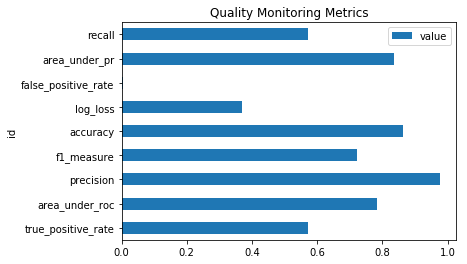

In [27]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value',title="Quality Monitoring Metrics");

# Fairness <a name="fairness"></a>

IBM Watson OpenScale helps in detection of Bias at run time. It monitors the data which has been sent to the model as well as the model prediction (Payload data). It then identifies bias.

The code below configures fairness monitoring for our model. It turns on monitoring for two features, Gender and Marital Status. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 80%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 500 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data. <br>
If Watson OpenScale reports a bias, it will be something that enterprises would want to fix. Watson OpenScale not only identify Fairness issues in the model at runtime, it also helps to automatically de-bias the models.<br>

In [28]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("GENDER_ID", majority=['Male'], minority=['X','Female'], threshold=0.80),
                Feature("MARITAL_STATUS", majority=["Single","Unmarried"], minority=["Married"], threshold=0.80)
            ],
            favourable_classes=[0],
            unfavourable_classes=[1],
            min_records=500,
            training_data=pd_data
        )

## Score the model again now that monitoring is configured

This next section randomly selects 3000 random records from the data feed and sends those records to the model for predictions. This is enough to exceed the minimum threshold for records set in the previous section, which allows OpenScale to begin calculating fairness.

In [29]:
scoring_data={'fields':fields,'values':pd_data[fields].sample(3000).values.tolist()}

payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [scoring_data]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)
print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

Single record scoring result: 
 fields: ['prediction', 'probability'] 
 values:  [0, [0.704840265129431, 0.295159734870569]]


### Run fairness monitor

Kick off a fairness monitor run on current data. The monitor runs hourly, but can be manually initiated using the Python client, the REST API, or the graphical user interface.

In [30]:
time.sleep(5)

run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=86206d47-d902-44ff-bb1e-b94ad74b58c5 




RUNNING........
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [31]:
subscription.fairness_monitoring.get_run_details()

{'metadata': {'asset_id': '0a03ad3e-a23a-4abc-8dc2-099995410f51',
  'data_mart_id': '00000000-0000-0000-0000-000000000000',
  'deployment_id': '86206d47-d902-44ff-bb1e-b94ad74b58c5',
  'subscription_id': '0a03ad3e-a23a-4abc-8dc2-099995410f51',
  'service_binding_id': '9778efab-4506-4a6d-a91e-d66ce9af6c83',
  'account_id': '1000331124',
  'created_at': '2020-09-17T10:08:28',
  'creator_id': '1000331124',
  'created_by': '1000331124',
  'modified_by': '1000331124'},
 'entity': {'parameters': {'features': [{'feature': 'GENDER_ID',
     'majority': ['Male'],
     'minority': ['X', 'Female'],
     'threshold': 0.8},
    {'feature': 'MARITAL_STATUS',
     'majority': ['Single', 'Unmarried'],
     'minority': ['Married'],
     'threshold': 0.8}],
   'class_label': 'prediction',
   'favourable_class': [0],
   'unfavourable_class': [1],
   'min_records': 500,
   'model_type': 'binary_classification',
   'last_run_info_code': 'AIQFM6005',
   'last_run_status': 'FINISHED',
   'last_run_message': 

In [32]:
time.sleep(5)

subscription.fairness_monitoring.show_table()

2020-09-17 10:07:17.644975+00:00,GENDER_ID,X,False,1.027,85.07936507936508,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5,
2020-09-17 10:07:17.644975+00:00,GENDER_ID,Female,False,0.98,83.72591006423983,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5,
2020-09-17 10:07:17.644975+00:00,MARITAL_STATUS,Married,True,0.741,67.4,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5,


From the above table, we could see bias in `MARITAL_STATUS` column. Watson OpenScale automatically de-biases the model and deploys it.

The debiased scoring endpoint can be viewed from the Evaluations window by navigating to **Configure Monitors -> Endpoints -> From the Endpoint list, select Debiased transactions -> From the Code language list, choose the type of code -> copy the code snippet**

Alternatively, it can be displayed as below.

In [33]:
try:
    debiased_scoring_URL= WOS_CREDENTIALS["url"]+"/v1/data_marts/"+subscription.fairness_monitoring.get_run_details()['metadata']['data_mart_id']+"/service_bindings/"+subscription.fairness_monitoring.get_run_details()['metadata']['service_binding_id']+"/subscriptions/"+subscription.fairness_monitoring.get_run_details()['metadata']['subscription_id']+"/deployments/"+subscription.fairness_monitoring.get_run_details()['metadata']['deployment_id']+"/online"

    print("De-biased scoring endpoint url\n",debiased_scoring_URL)
except:
    print("De-Biased Model not found")
    generate_dashboard_data=False

De-biased scoring endpoint url
 https://dse-cp4d301-cluster1.datascienceelite.com/v1/data_marts/00000000-0000-0000-0000-000000000000/service_bindings/9778efab-4506-4a6d-a91e-d66ce9af6c83/subscriptions/0a03ad3e-a23a-4abc-8dc2-099995410f51/deployments/86206d47-d902-44ff-bb1e-b94ad74b58c5/online


The data can be scored against the debiased model and result can be saved and used for r-shiny dashboard by making the below variable `True` 

In [34]:
generate_dashboard_data=False

Additionally, user can score all their records on de-biased model and compare the predictions for both original and de-biased model using the below code. It also displays sample customers whose biased predictions were reversed by the openscale.

In [35]:
if(generate_dashboard_data):
    try:
        print("Authenticating ..")
        credentials = WOS_CREDENTIALS["username"] + ':' + WOS_CREDENTIALS["password"]
        basicAuth = base64.b64encode(credentials.encode('utf-8'))
        basicAuth = basicAuth.decode('utf-8')

        headers={}
        headers['Authorization']='Basic %s' %  basicAuth
        response = requests.get(WOS_CREDENTIALS["url"]+"/v1/preauth/validateAuth", headers = headers,verify=False)
        jsonResponse = json.loads(response.text)
        token = jsonResponse["accessToken"]
        values= pd_data[fields].values.tolist()

        headers = {"Authorization":"Bearer " + token,"content-type":"application/json", "Accept":"application/json"}

        #example payload
        payload = {
        "fields": fields,
            "values": values
        }
        print("Scoring all the records on de-biased endpoints ..")
        response = requests.post(debiased_scoring_URL, data=json.dumps(payload), headers=headers,verify = False)
        df_response=pd.DataFrame(json.loads(response.text)['values'],columns=json.loads(response.text)['fields'])
        pd_data[["Prob_against","predicted_probability"]]=pd.DataFrame(df_response.debiased_probability.tolist(), index= df_response.index)
        pd_data[["Biased_Prob_against","Biased_predicted_probability"]]=pd.DataFrame(df_response.probability.tolist(), index= df_response.index)
        
        
        pd_data[["predicted_class","predicted_class_biased"]]=df_response[["debiased_prediction","prediction"]]
        biased_sample=pd_data[pd_data['Biased_predicted_probability']!=pd_data['predicted_probability']][['CUSTOMER_ID','FIRST_NAME', 'LAST_NAME','GENDER_ID','MARITAL_STATUS','Biased_predicted_probability','predicted_class_biased','predicted_probability','predicted_class']].head()
        biased_sample.columns=['CUSTOMER_ID','FIRST_NAME', 'LAST_NAME','GENDER_ID','MARITAL_STATUS','Predicted_Probability_Original','Predicted_Class_Original','Predicted_Probability_De-biased','Predicted_Class_De-biased']
        print("Sample customers whose attrition probabilities changed by the de-biased model")
        display(biased_sample)
        pd_data["actual"]=pd_data["ATTRITION_STATUS"]
        pd_data['dataset']="Unseen"
        project.save_data('model output summary.csv', pd_data.to_csv(index=False), overwrite=True)
        print("Csv file generated and stored in data assets.")
    except:
        print("Csv file couldn't be generated by scoring the de-biased endpoints. Please check the variables and try again")



## Configure Explainability <a name="explain"></a>

We provide OpenScale with the training data to enable and configure the explainability features. Watson OpenScale provides LIME based and Contrastive explanations for the specified transactions.

In [36]:
from ibm_ai_openscale.supporting_classes import *
subscription.explainability.enable(training_data=pd_data[all_fields])

In [37]:
explainability_details = subscription.explainability.get_details()
explainability_details

{'enabled': True,
 'monitor_definition': {'entity': {'applies_to': {'input_data_type': ['structured',
     'unstructured_image',
     'unstructured_text'],
    'problem_type': ['binary', 'multiclass', 'regression']},
   'description': 'Provides explanations to the predictions made by a Machine Learning model.',
   'metrics': [],
   'monitor_runtime': {'type': 'service'},
   'name': 'Explainability',
   'parameters_schema': {'properties': {'tokenizer': {'$id': '#/properties/tokenizer',
      'items': {'$id': '#/properties/tokenizer/items',
       'properties': {'enabled': {'$id': '#/properties/tokenizer/items/properties/enabled',
         'type': 'boolean'},
        'language': {'$id': '#/properties/tokenizer/items/properties/language',
         'type': 'string'},
        'part_of_speech': {'$id': '#/properties/tokenizer/items/properties/part_of_speech',
         'items': {'oneOf': [{'type': 'string'}]},
         'type': 'array'}},
       'required': ['enabled'],
       'title': 'The to

### Run explanation for sample record

A sample record/s can be picked from a `payload_logging` table and then explaination can be run on the sample record/s. 

In [38]:
transaction_id = subscription.payload_logging.get_table_content(limit=10)['scoring_id'].values[0]
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 43637096-caf1-4355-af85-8d86c8714904-372 




in_progress.........
finished

---------------------------
 Successfully finished run 
---------------------------




The explaination for a transaction can be visualized as below. If the explaination doesn't finish in 180 seconds, then wait for a minute to run the below cell.

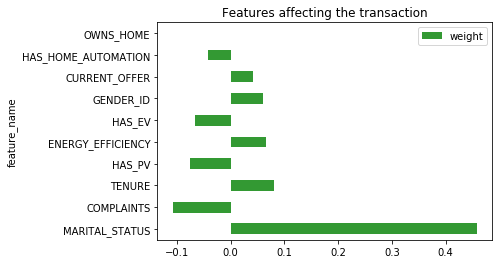

In [39]:
if explain_run == None:
    # explanation didn't finish within 180 seconds, if explaination is still not finished give it a minute or so then re-run this cell
    time.sleep(10)
    explain_table = subscription.explainability.get_table_content(format='pandas')
    explain_result = pd.DataFrame.from_dict(explain_table[explain_table['transaction_id']==transaction_id]['explanation'][0]['entity']['predictions'][0]['explanation_features'])
else:
    explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])

explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8,title="Features affecting the transaction");

## Drift configuration <a name="drift"></a>

The drift is measured as the drop in accuracy as compared to the model accuracy at training time. 
Below cell enables the drift monitor with 100 minimum record and 10% of threshold. If the drift for a model drops below the specified threshold, then OpenScale will generate an alert for the user. Once the drift is enabled, then drift monitor will be kicked off using `drift_monitoring` library.

In [40]:
subscription.drift_monitoring.enable(min_records=100, threshold=0.1)

drift_status = None
while drift_status != 'finished':
    drift_details = subscription.drift_monitoring.get_details()
    drift_status = drift_details['parameters']['config_status']['state']
    if drift_status != 'finished':
        #print(datetime.utcnow().strftime('%H:%M:%S'), drift_status)
        time.sleep(30)
print(drift_status)
drift_details['parameters']['config_status']

finished


{'state': 'finished'}

In [41]:
drift_run_details = subscription.drift_monitoring.run(background_mode=False)




 Waiting for end of drift monitoring run  




RUNNING..
COMPLETED

---------------------------
 Successfully finished run 
---------------------------




In [42]:
subscription.drift_monitoring.get_table_content()

,ts,id,measurement_id,value,lower limit,upper limit,tags,binding_id,subscription_id,deployment_id
0,2020-09-17 10:13:28.629412+00:00,data_drift_magnitude,a225111e-33c7-4385-aac3-ec8feb122c12,0.010,,,,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
1,2020-09-17 10:13:28.629412+00:00,drift_magnitude,a225111e-33c7-4385-aac3-ec8feb122c12,0.005,,0.1,,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5
2,2020-09-17 10:13:28.629412+00:00,predicted_accuracy,a225111e-33c7-4385-aac3-ec8feb122c12,0.777,,,,9778efab-4506-4a6d-a91e-d66ce9af6c83,0a03ad3e-a23a-4abc-8dc2-099995410f51,86206d47-d902-44ff-bb1e-b94ad74b58c5


The above table decribes following metrics.
1. `data_drift_magnitude` - Drop in data consistency.
2. `drift_magnitude` - Drop in accuracy.
3. `predicted_accuracy` - Accuracy of the sample data.


Now that quality, fairness, explaination and drift are configured navigate to `{HOST}/aiopenscale/insights/{deployment_id}` to see the monitors. The homepage of the `Utilities Customer Attrition Deployment` monitor would look something like below. Click on each measures to see the results. 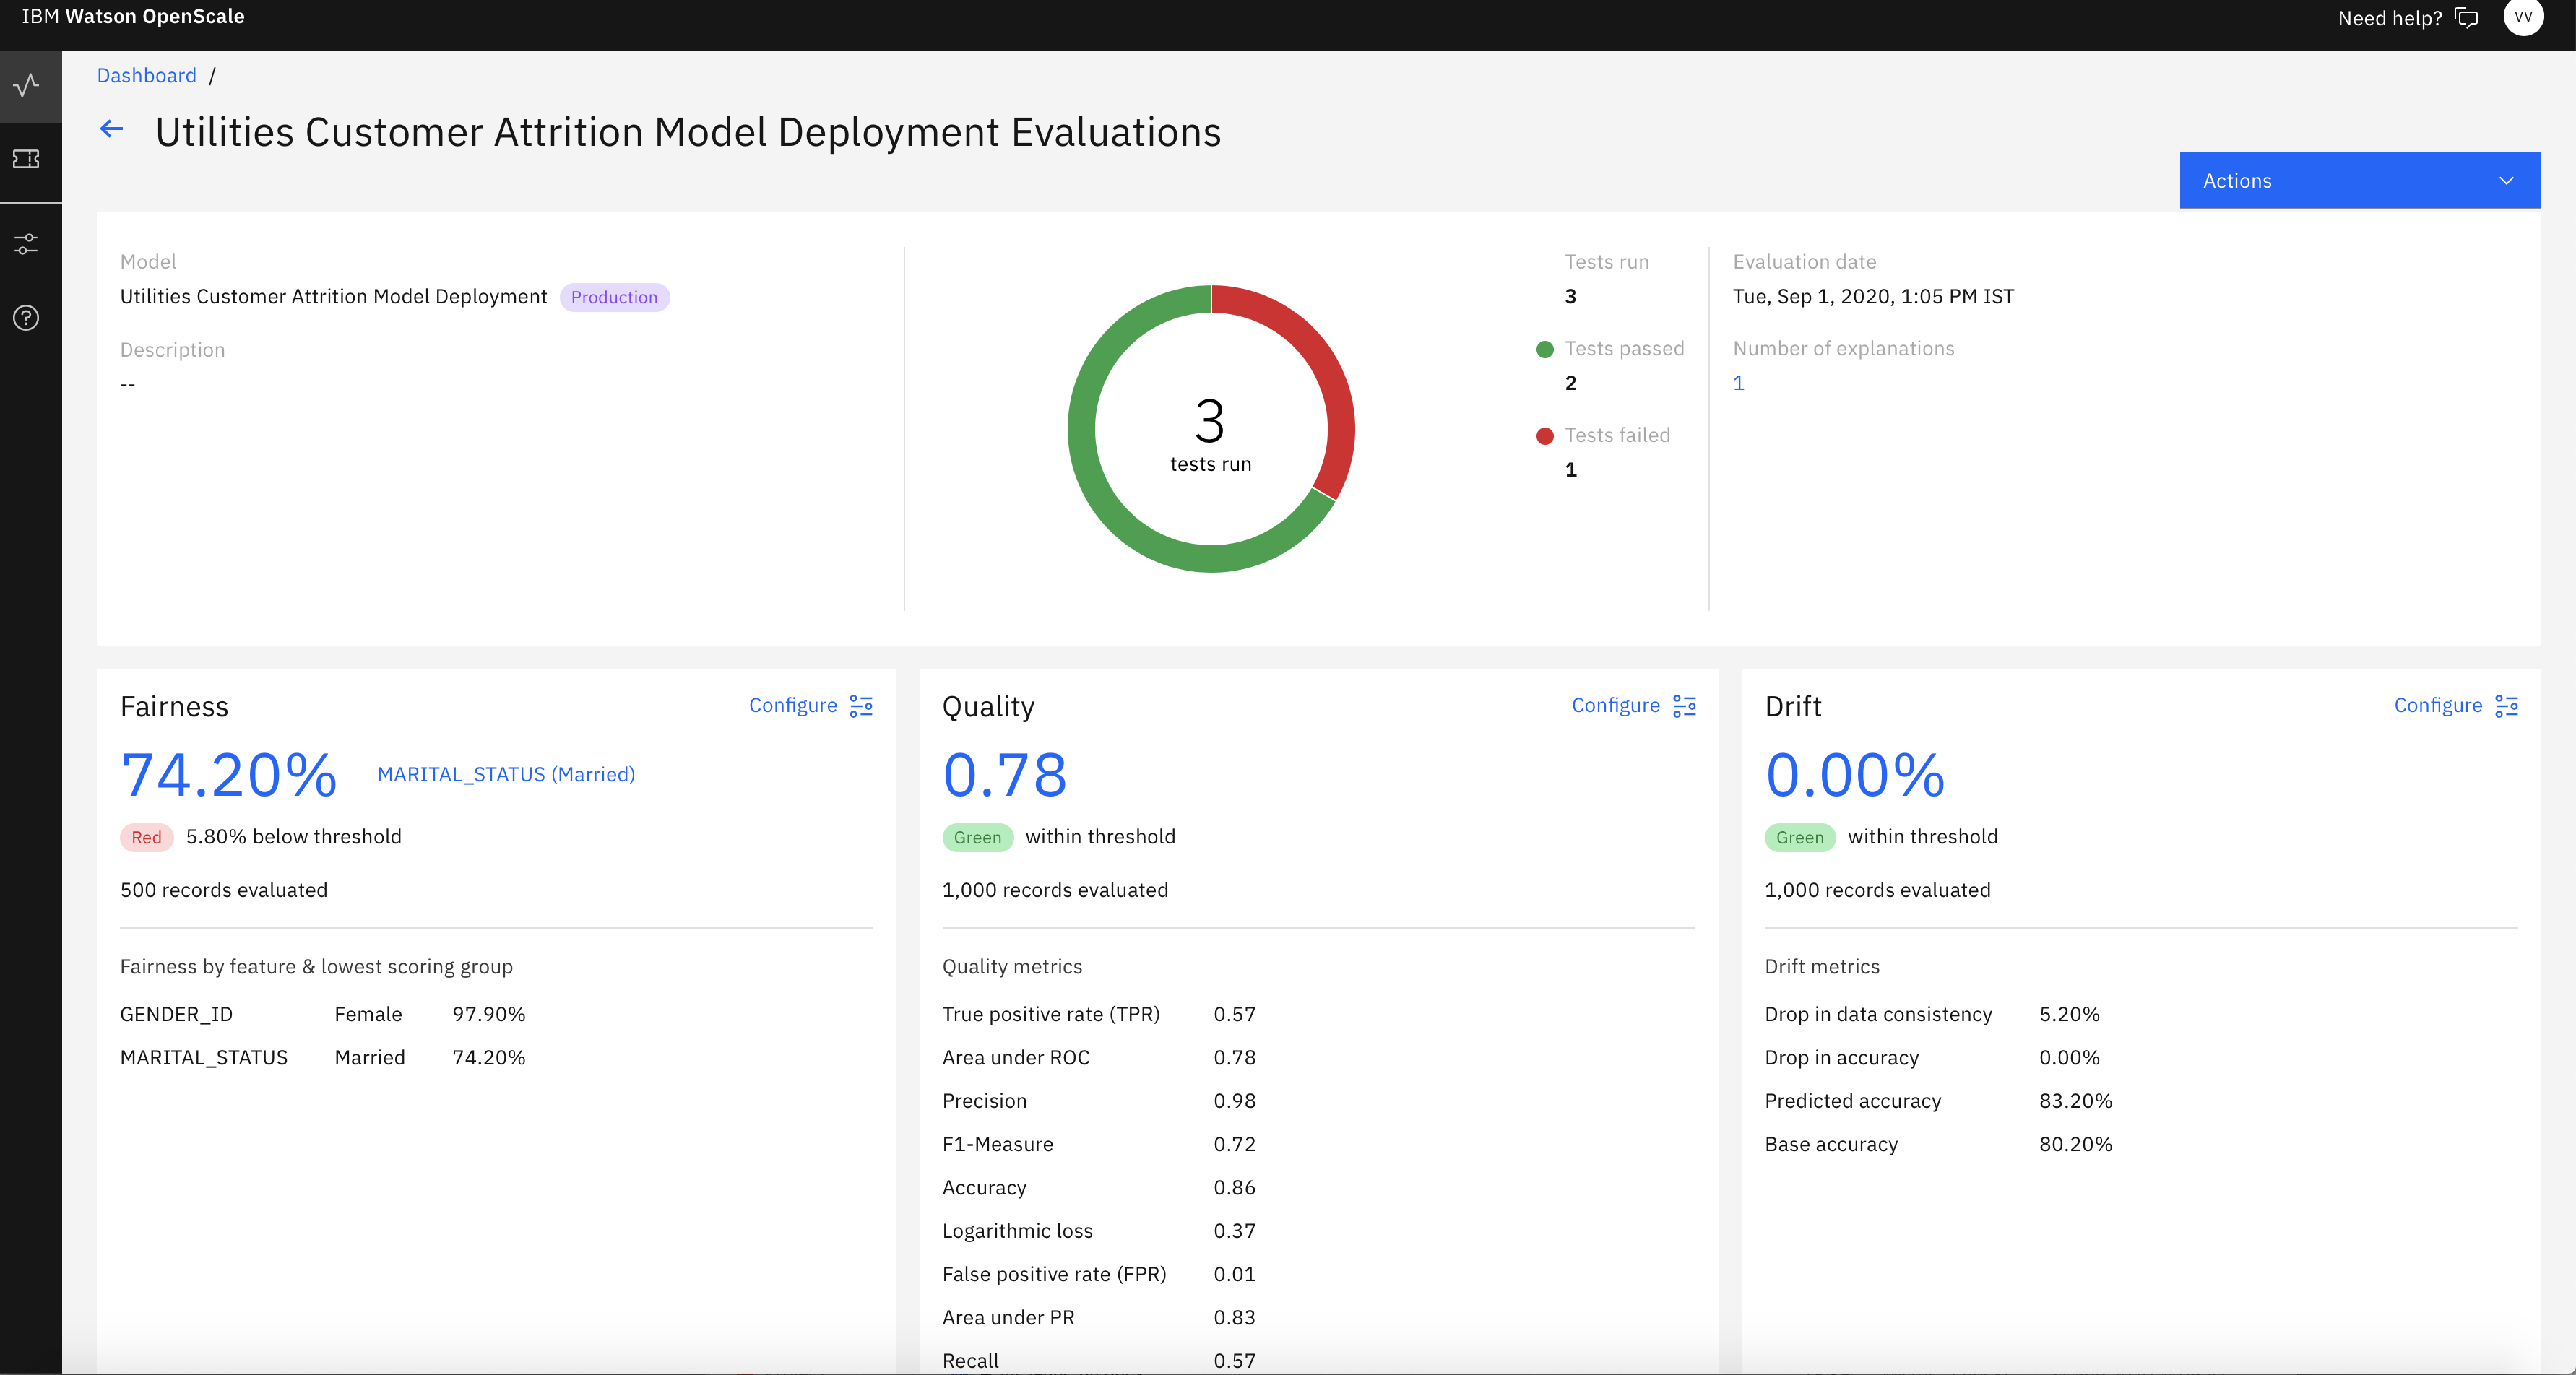

Now see **3-App_deployment** to predict customer attrition on sample data and then deploy r-shiny dashboard